In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing


From the previous study, one thing we can conclude is that during the period of 2019-2022, due to Covid, the amount of reviews, either positive or negative, drastically dropped.
With this in mind, let's try to do the following: let's tag each review between 2020 and 2022 as "covid" and let's see if the ARIMA model makes a new prediction

### Mark reviews as 'Covid'
Through searching on the Internet, we concluded that it was on around march of 2020 that a lockdown was set in New Orleans and it was lifted in May of 2022. Therefore, we decided to consider all the reviews from March 1st of 2020 to May of 2022 as 'Covid' and the rest as 'Non-Covid'.

In [4]:
# Load the data from the JSON file
with open('./datasets/review_dataset_new_orleans_sentiment.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data = "[" + ','.join(data) + "]"

    # Load the data into a DataFrame
    data = pd.read_json(data)

print(data.head())

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Tag reviews between March 2020 and 2022 as "COVID"
data['covid'] = data['date'].apply(lambda x: 'COVID' if (x >= datetime(2020, 3, 1)) and (x <= datetime(2022, 12, 31)) else 'non-COVID')

# Check the taggings
print(data['covid'].value_counts())



/var/folders/y1/sdj8rxp944zc_kqcq6lcl6jh0000gn/T/ipykernel_45187/1482044186.py:8: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  data = pd.read_json(data)


                    review_id  sentiment                date
0  rev_Sx8TMOWLNuJBWer-0pcmoA          1 2017-01-14 20:54:15
1  rev_6AxgBCNX_PNTOxmbRSwcKQ          1 2015-01-03 23:21:18
2  rev_z0osLHDvXvzfm57D4DmD2Q          1 2016-11-22 00:22:53
3  rev_jC-fGfx-YLqxVBcyTAd4Pw          1 2013-12-29 02:37:42
4  rev_Ki90-hauSIfW_7sBuBBqfA          1 2014-06-11 14:55:14
covid
non-COVID    569278
COVID         66086
Name: count, dtype: int64


### Separate data (as 'pre-COVID' and 'COVID') and aggregate data by year

To ensure that categorizing reviews as "covid" has a significant impact on the analysis, we must explicitly account for the COVID period in the model. This includes dividing the data into pre-COVID and COVID periods.

In [5]:
data['year'] = data['date'].dt.year
data['positive'] = data['sentiment'].apply(lambda x: 1 if x == 1 else 0)
data['negative'] = data['sentiment'].apply(lambda x: 1 if x == 0 else 0)

yearly_data = data.groupby('year').agg({'positive': 'sum', 'negative': 'sum'}).reset_index()

# Apply rolling average to smooth the data
window_size = 3
yearly_data['positive_smoothed'] = yearly_data['positive'].rolling(window=window_size).mean()
yearly_data['negative_smoothed'] = yearly_data['negative'].rolling(window=window_size).mean()

# Separate the data into pre-COVID and COVID periods
pre_covid_data = yearly_data[yearly_data['year'] < 2020]
covid_data = yearly_data[(yearly_data['year'] >= 2020) & (yearly_data['year'] <= 2022)]



# pre_covid_data = data[data['covid'] == 'Non-COVID']
# covid_data = data[data['covid'] == 'COVID']

# # Create positive and vegative sentiment columns
# pre_covid_data['positive'] = np.where(pre_covid_data['sentiment'] == 1, 1, 0)
# pre_covid_data['negative'] = np.where(pre_covid_data['sentiment'] == 0, 1, 0)

# covid_data['positive'] = np.where(covid_data['sentiment'] == 1, 1, 0)
# covid_data['negative'] = np.where(covid_data['sentiment'] == 0, 1, 0)

# # Group the data by date and calculate the sum of positive and negative reviews
# pre_covid_data_date = pre_covid_data.groupby('date').agg({'positive': 'sum', 'negative': 'sum'}).reset_index()
# covid_data_date = covid_data.groupby('date').agg({'positive': 'sum', 'negative': 'sum'}).reset_index()

# pre_covid_data_date['positive_change'] = pre_covid_data_date['positive'].pct_change() * 100
# pre_covid_data_date['negative_change'] = pre_covid_data_date['negative'].pct_change() * 100

# covid_data_date['positive_change'] = covid_data_date['positive'].pct_change() * 100
# covid_data_date['negative_change'] = covid_data_date['negative'].pct_change() * 100

# # Apply rolling average to smooth the data
# pre_covid_data_date['positive_smoothed'] = pre_covid_data_date['positive'].rolling(window=3).mean()
# pre_covid_data_date['negative_smoothed'] = pre_covid_data_date['negative'].rolling(window=3).mean()

# covid_data_date['positive_smoothed'] = covid_data_date['positive'].rolling(window=3).mean()
# covid_data_date['negative_smoothed'] = covid_data_date['negative'].rolling(window=3).mean()

### Fit new ARIMA Model and new Predictions

In [6]:
# Fit ARIMA model for positive sentiment (pre-COVID)
positive_model_pre_covid = ARIMA(pre_covid_data['positive_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("Pre-COVID Positive Sentiment Model Summary")
print(positive_model_pre_covid.summary())

# Fit ARIMA model for positive sentiment (COVID period)
positive_model_covid = ARIMA(covid_data['positive_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("COVID Period Positive Sentiment Model Summary")
print(positive_model_covid.summary())

# Forecast for the next 5 years for positive sentiment (pre-COVID)
positive_forecast_pre_covid = positive_model_pre_covid.forecast(steps=5)
print('Positive Sentiment Forecast (Pre-COVID):', positive_forecast_pre_covid)

# Forecast for the next 5 years for positive sentiment (COVID period)
positive_forecast_covid = positive_model_covid.forecast(steps=5)
print('Positive Sentiment Forecast (COVID Period):', positive_forecast_covid)

# Repeat the same process for negative sentiment
negative_model_pre_covid = ARIMA(pre_covid_data['negative_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("Pre-COVID Negative Sentiment Model Summary")
print(negative_model_pre_covid.summary())

negative_model_covid = ARIMA(covid_data['negative_smoothed'].dropna(), order=(1, 0, 1)).fit()
print("COVID Period Negative Sentiment Model Summary")
print(negative_model_covid.summary())

negative_forecast_pre_covid = negative_model_pre_covid.forecast(steps=5)
print('Negative Sentiment Forecast (Pre-COVID):', negative_forecast_pre_covid)

negative_forecast_covid = negative_model_covid.forecast(steps=5)
print('Negative Sentiment Forecast (COVID Period):', negative_forecast_covid)



# # Fit ARIMA model for positive sentiment (pre-COVID)
# positive_model_pre_covid = ARIMA(pre_covid_data_date['positive_smoothed'], order=(1, 0, 1)).fit()
# print("Pre-COVID Positive Sentiment Model Summary")
# print(positive_model_pre_covid.summary())

# # Fit ARIMA model for positive sentiment (COVID period)
# positive_model_covid = ARIMA(covid_data_date['positive_smoothed'], order=(1, 0, 1)).fit()
# print("COVID Positive Sentiment Model Summary")
# print(positive_model_covid.summary())

# # Forecast for the next 5 years for positive sentiment (pre-COVID)
# positive_forecast_pre_covid = positive_model_pre_covid.forecast(steps=5)
# print('Positive Sentiment Forecast (Pre-COVID):', positive_forecast_pre_covid)

# # Forecast for the next 5 years for positive sentiment (COVID period)
# positive_forecast_covid = positive_model_covid.forecast(steps=5)
# print('Positive Sentiment Forecast (COVID):', positive_forecast_covid)

# # Repeat the same process for negative sentiment

# # Fit ARIMA model for negative sentiment (pre-COVID)
# negative_model_pre_covid = ARIMA(pre_covid_data_date['negative_smoothed'], order=(1, 0, 1)).fit()
# print("Pre-COVID Negative Sentiment Model Summary")
# print(negative_model_pre_covid.summary())

# # Fit ARIMA model for negative sentiment (COVID period)
# negative_model_covid = ARIMA(covid_data_date['negative_smoothed'], order=(1, 0, 1)).fit()
# print("COVID Negative Sentiment Model Summary")
# print(negative_model_covid.summary())

# # Forecast for the next 5 years for negative sentiment (pre-COVID)
# negative_forecast_pre_covid = negative_model_pre_covid.forecast(steps=5)
# print('Negative Sentiment Forecast (Pre-COVID):', negative_forecast_pre_covid)

# # Forecast for the next 5 years for negative sentiment (COVID period)
# negative_forecast_covid = negative_model_covid.forecast(steps=5)
# print('Negative Sentiment Forecast (COVID):', negative_forecast_covid)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

Pre-COVID Positive Sentiment Model Summary
                               SARIMAX Results                                
Dep. Variable:      positive_smoothed   No. Observations:                   13
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -129.454
Date:                Sat, 18 May 2024   AIC                            266.908
Time:                        01:12:30   BIC                            269.167
Sample:                             0   HQIC                           266.443
                                 - 13                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.465e+04   4.41e+04      0.785      0.432   -5.18e+04    1.21e+05
ar.L1          0.9786      0.116      8.457      0.000       0.752       1.205
ma.L1    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3158: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3158: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: Fut

### Compare forecasts

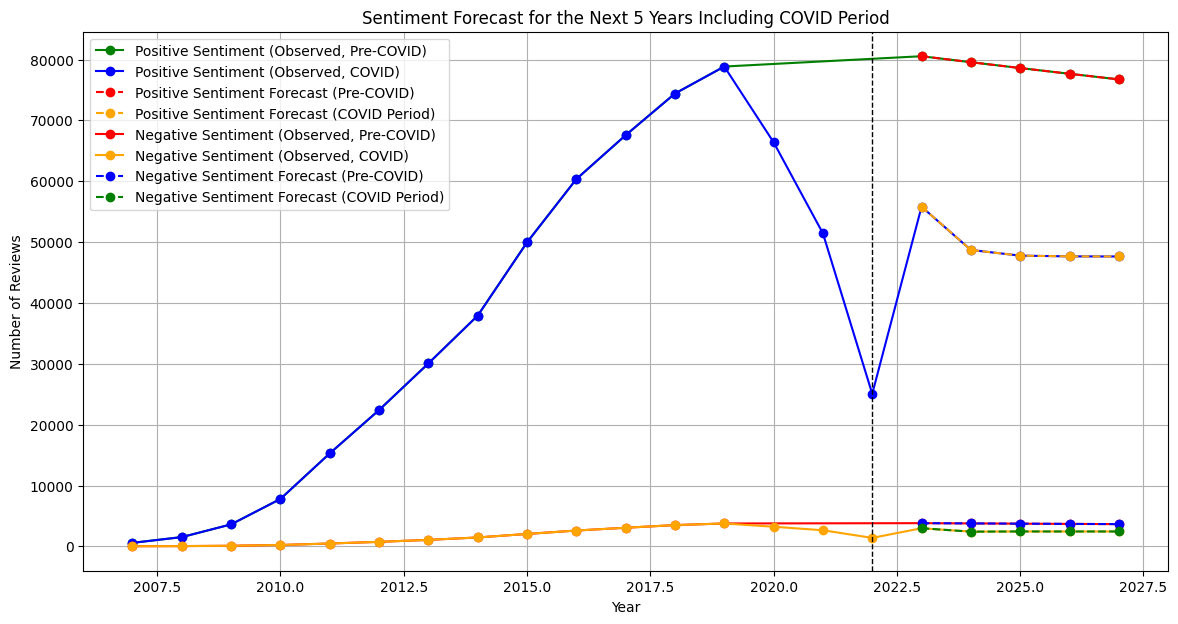

In [7]:
# Extend the yearly data to include forecasted years
forecast_years = list(range(yearly_data['year'].max() + 1, yearly_data['year'].max() + 6))
forecast_index = pd.concat([yearly_data['year'], pd.Series(forecast_years)], ignore_index=True)

# Append the forecasted data to the original data
pre_covid_data_date = pd.concat([pre_covid_data, pd.DataFrame({'year': forecast_years, 'positive_smoothed': positive_forecast_pre_covid, 'negative_smoothed': negative_forecast_pre_covid})], ignore_index=True)
covid_data_date = pd.concat([yearly_data, pd.DataFrame({'year': forecast_years, 'positive_smoothed': positive_forecast_covid, 'negative_smoothed': negative_forecast_covid})], ignore_index=True)

plt.figure(figsize=(14, 7))

# Positive Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, Pre-COVID)', color='green', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, COVID)', color='blue', marker='o')
plt.plot(forecast_years, positive_forecast_pre_covid, label='Positive Sentiment Forecast (Pre-COVID)', color='red', linestyle='dashed', marker='o')
plt.plot(forecast_years, positive_forecast_covid, label='Positive Sentiment Forecast (COVID Period)', color='orange', linestyle='dashed', marker='o')

# Negative Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, Pre-COVID)', color='red', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, COVID)', color='orange', marker='o')
plt.plot(forecast_years, negative_forecast_pre_covid, label='Negative Sentiment Forecast (Pre-COVID)', color='blue', linestyle='dashed', marker='o')
plt.plot(forecast_years, negative_forecast_covid, label='Negative Sentiment Forecast (COVID Period)', color='green', linestyle='dashed', marker='o')

# Add vertical line to separate observed and forecasted periods
plt.axvline(x=2022, color='black', linestyle='--', linewidth=1)

plt.title('Sentiment Forecast for the Next 5 Years Including COVID Period')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True)
plt.show()

As shown in the graph, categorizing reviews as 'COVID' or 'non-COVID' results in a clear difference in the forecast of both positive and negative reviews. Without considering the covid reviews, it is clear that, using the ARIMA model, positive ratings will climb over the following five years, peaking around 2023. Following that, the reviews would remain stagnant, with a gradual fall over the following years. However, when compared to the projection based on the covid data, the number of reviews is significantly larger (approximately 80000).

Regarding bad reviews, while we can still confirm the trend of negative reviews flatlining over the next 5 years, the only notable change is that the quantity of negative reviews will be higher than those produced using Covid data for training.

Now let's check if, with this tagging method, the Exponential Smoothing model shows better results. As we have seen in the previous notebook, this model, especially in the forecast of positive reviews, was greatly affected by the pandemic.

Pre-COVID Positive Sentiment Model Summary
Positive Sentiment Forecast (Pre-COVID): 13     85663.362909
14     92465.902984
15     99268.443059
16    106070.983134
17    112873.523210
dtype: float64
Positive Sentiment Forecast (COVID Period): 3    13923.946965
4    -1046.312935
5   -16016.572835
6   -30986.832735
7   -45957.092634
dtype: float64
Pre-COVID Negative Sentiment Model Summary
Negative Sentiment Forecast (Pre-COVID): 13    4039.532697
14    4312.357600
15    4585.182503
16    4858.007406
17    5130.832309
dtype: float64
Negative Sentiment Forecast (COVID Period): 3     592.206928
4    -324.466028
5   -1241.138985
6   -2157.811941
7   -3074.484897
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/ts

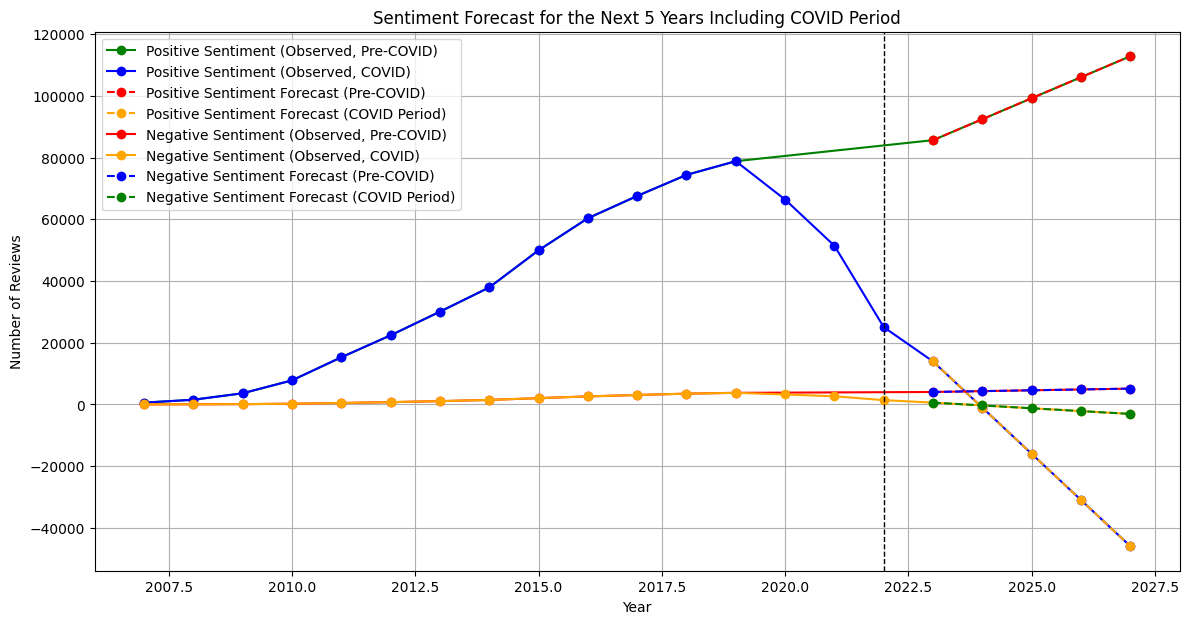

In [8]:
# Fit the Exponential Smoothing model for positive sentiment (pre-COVID)
positive_model_pre_covid = ExponentialSmoothing(pre_covid_data['positive_smoothed'].dropna(), trend='add').fit()
print("Pre-COVID Positive Sentiment Model Summary")

# Fit the Exponential Smoothing model for positive sentiment (COVID period)
positive_model_covid = ExponentialSmoothing(covid_data['positive_smoothed'].dropna(), trend='add').fit()

# Forecast for the next 5 years for positive sentiment (pre-COVID)
positive_forecast_pre_covid = positive_model_pre_covid.forecast(steps=5)
print('Positive Sentiment Forecast (Pre-COVID):', positive_forecast_pre_covid)

# Forecast for the next 5 years for positive sentiment (COVID period)
positive_forecast_covid = positive_model_covid.forecast(steps=5)
print('Positive Sentiment Forecast (COVID Period):', positive_forecast_covid)

# Repeat the same process for negative sentiment
negative_model_pre_covid = ExponentialSmoothing(pre_covid_data['negative_smoothed'].dropna(), trend='add').fit()
print("Pre-COVID Negative Sentiment Model Summary")

negative_model_covid = ExponentialSmoothing(covid_data['negative_smoothed'].dropna(), trend='add').fit()

negative_forecast_pre_covid = negative_model_pre_covid.forecast(steps=5)
print('Negative Sentiment Forecast (Pre-COVID):', negative_forecast_pre_covid)

negative_forecast_covid = negative_model_covid.forecast(steps=5)
print('Negative Sentiment Forecast (COVID Period):', negative_forecast_covid)

# Append the forecasted data to the original data
pre_covid_data_date = pd.concat([pre_covid_data, pd.DataFrame({'year': forecast_years, 'positive_smoothed': positive_forecast_pre_covid, 'negative_smoothed': negative_forecast_pre_covid})], ignore_index=True)
covid_data_date = pd.concat([yearly_data, pd.DataFrame({'year': forecast_years, 'positive_smoothed': positive_forecast_covid, 'negative_smoothed': negative_forecast_covid})], ignore_index=True)

plt.figure(figsize=(14, 7))

# Positive Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, Pre-COVID)', color='green', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['positive_smoothed'], label='Positive Sentiment (Observed, COVID)', color='blue', marker='o')
plt.plot(forecast_years, positive_forecast_pre_covid, label='Positive Sentiment Forecast (Pre-COVID)', color='red', linestyle='dashed', marker='o')
plt.plot(forecast_years, positive_forecast_covid, label='Positive Sentiment Forecast (COVID Period)', color='orange', linestyle='dashed', marker='o')

# Negative Sentiment
plt.plot(pre_covid_data_date['year'], pre_covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, Pre-COVID)', color='red', marker='o')
plt.plot(covid_data_date['year'], covid_data_date['negative_smoothed'], label='Negative Sentiment (Observed, COVID)', color='orange', marker='o')
plt.plot(forecast_years, negative_forecast_pre_covid, label='Negative Sentiment Forecast (Pre-COVID)', color='blue', linestyle='dashed', marker='o')
plt.plot(forecast_years, negative_forecast_covid, label='Negative Sentiment Forecast (COVID Period)', color='green', linestyle='dashed', marker='o')

# Add vertical line to separate observed and forecasted periods
plt.axvline(x=2022, color='black', linestyle='--', linewidth=1)

plt.title('Sentiment Forecast for the Next 5 Years Including COVID Period')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True)
plt.show()


With this graph is easy to see a major difference in the way forecasts are done, when using Covid-19 data or not. In this model's particular case, we can see that, using only pre-Covid reviews, it has been predicted that the number of positive reviews will rise to approximately 120000 until 2008, which is more plausable than the original prediction. It's also worth pointing out the difference found in the negative reviews. Without Covid data, the negative reviews continue stable, having a slight increase around 2026.

This graph therefore is a great example to show off the affects of Covid-19 in the model's performance. he pre-COVID forecasts for both sentiments show a reasonable continuation of trends observed before the pandemic, suggesting the model is better suited for stable periods, while the COVID period forecasts reveal limitations, as the model struggles to adapt to the abrupt changes introduced by the pandemic